In [1]:
import os
import sys
import time
import glob
import shutil
import argparse
import subprocess
import numpy as np
import pandas as pd

In [2]:
base_dir = "./"

labels_fname = base_dir+"data/ALL.info.complete"

min_coverage = 100
train_fraction=80
min_samples = 10
max_sample_frac = 80 # maximum percentage of the samples from a tissue to be considered passing

num_threads=40

In [ ]:
if not os.path.exists(base_dir+"step2/"):
    os.makedirs(base_dir+"step2/")


aln_dirs = ["./GTEx_2019_hisat2/",
            "./GTEx_2019_hisat2_new134/",
            "./GTEx_2019_hisat2_single_end/"]

tissue2samples = dict()

for aln_dir in aln_dirs:
    for cram_fp in glob.glob(aln_dir+"*/*cram"):
        tissue = cram_fp.split("/")[-2]
        tissue2samples.setdefault(tissue,[]).append(cram_fp)

print(list(tissue2samples))

for tissue in sorted(list(tissue2samples))[::-1]:    
    sjs_fname = base_dir+"step1/"+tissue+"/"+tissue+".sjs.stats"
    introns_fname = base_dir+"step1/"+tissue+"/"+tissue+".assembled.introns"
    outfname = base_dir+"step2/"+tissue+"/"+tissue
    
    print(sjs_fname)
    if not os.path.exists(sjs_fname):
        continue
    
    if not os.path.exists(base_dir+"step2/"+tissue+"/"):
        os.makedirs(base_dir+"step2/"+tissue+"/")
    
    min_tissue_samples = min(min_samples,int(len(tissue2samples[tissue])*(max_sample_frac/100)))
    
    print(tissue)
    
    model_cmd = [base_dir+"soft/scripts/nitron/nitron.py","model",
                 '--reference',"refseq_vs_gencode_intersection.prot_lnc.no_alts.no_fixs.clean.gff",
                 '--junctions',sjs_fname,
                 '--introns',introns_fname,
                 '--output',outfname,
                 '--threads',str(num_threads),
                 '--coverage',str(min_coverage),
                 '--fraction',str(train_fraction)]
    print(" ".join(model_cmd))
    subprocess.call(model_cmd)
    
    
    extract_cmd = [base_dir+"soft/scripts/nitron/nitron.py","extract",
                   '--labels',labels_fname,
                   '--assembly',base_dir+"step1/ALL."+tissue+".gtf",
                   '--novel_introns',base_dir+"soft/scripts/genomic_scripts/novel_introns/novel_introns1",
                   '--output',outfname,
                   '--threads',str(num_threads),
                   '--min_samples',str(min_tissue_samples),
                   '--predictions',base_dir+"step2/"+tissue+"/"+tissue+".nitron.preds",
                   '--all_known_assembled_labeled',base_dir+"data/latest_gtfs/gffcmp_multi.27M/27M.known.refseq_gencode.gtf",
                   '--tb_filtered_tissue_gtf',"./tiebrush/filtered_GTEx/"+tissue+".tb.filt_3_3.gtf"]
    print(" ".join(extract_cmd))
    subprocess.call(extract_cmd)

In [ ]:
def load_final_tissue_tids(fname,d):
    with open(fname,"r") as inFP:
        for line in inFP:
            if line[0]=="#":
                continue
            lineCols = line.strip("\n").split("\t")
            if lineCols[2]=="transcript":
                tid = lineCols[8].split("transcript_id \"",1)[1].split("\"",1)[0]
                assert tid not in d,"duplicate tid: "+tid
                d.setdefault(tid,dict())
                tmp = lineCols[8].split("; tpms \"",1)[1].split("\"",1)[0].split(",")
                tpm = np.mean([float(x ) for x in tmp])
                num_samples = len(tmp)
                d[tid]["tpm"] = tpm
                d[tid]["num_samples"] = num_samples

def assign_kv(d,nk,nv): # assigns a key value pair to each element of the 
    for k,v in d.items():
        if nk in v:
            assert v[nk]==nv,"values do not match"
        else:
            v.setdefault(nk,nv)

def merge_tids(din,dm,set_items): # set items will be collapsed
    for k,v in din.items():
        if k in dm:
            for k1,v1 in v.items():
                if k1 in dm[k]:
                    dm[k][k1].append(v1)
                else:
                    dm[k][k1] = [v1]
                
                if k1 in set_items:
                    dm[k][k1] = list(set(dm[k][k1]))
        else:
            dm[k] = dict()
            for k1,v1 in v.items():
                dm[k][k1] = [v1]
                if k1 in set_items:
                    dm[k][k1] = list(set(dm[k][k1]))

                
def combine(suff):
    all_tids = dict()
    for tissue in sorted(list(tissue2samples))[::-1]:
        novel_fname = base_dir+"step2/"+tissue+"/"+tissue+".novel"+suff+".gtf"
        single_fname = base_dir+"step2/"+tissue+"/"+tissue+".novel_single_exon.pass.gtf"
        known_fname = base_dir+"step2/"+tissue+"/"+tissue+".ordered.known.gtf"
        
        if not os.path.exists(known_fname):
            continue
        
        print(tissue)

        known_tids = dict()
        load_final_tissue_tids(known_fname,known_tids)
        assign_kv(known_tids,"tissue",tissue)
        assign_kv(known_tids,"type","known")

        novel_tids = dict()
        load_final_tissue_tids(novel_fname,novel_tids)
        load_final_tissue_tids(single_fname,novel_tids)
        assign_kv(novel_tids,"tissue",tissue)
        assign_kv(novel_tids,"type","novel")

        merge_tids(novel_tids,all_tids,["type"])
        merge_tids(known_tids,all_tids,["type"])

    print(suff.upper()+" - number of transcripts: "+str(len(all_tids)))
    
    # write the final set out as a single gtf
    out_all_fname = base_dir+"step2/all"+suff+".gtf"
    with open(out_all_fname,"w+") as outFP:
        with open(base_dir+"/data/latest_gtfs/27M.primary.gtf","r") as inFP:
            for line in inFP:
                if line[0]=="#":
                    outFP.write(line)

                lcs = line.rstrip().split("\t")
                if len(lcs)<9:
                    continue

                tid = lcs[8].split("transcript_id \"",1)[1].split("\"",1)[0]
                if tid in all_tids:
                    if lcs[2]=="transcript":
                        attrs = "transcript_id \""+tid+"\"; "
                        for k,v in all_tids[tid].items():
                            attrs+=k+" \""
                            for el in v:
                                if isinstance(el,float):
                                    el = str(round(el, 2))
                                attrs+=str(el)+","
                            attrs = attrs[:-1]+"\"; "
                        lcs[8] = attrs
                    line = "\t".join(lcs)
                    outFP.write(line+"\n")
    
    
combine("_min")
combine("_allg")
combine("_all")

In [6]:
# overlaps between novel transcripts in the 3 sets

novel_tid_suff_dict = dict()

for suff in ["_min","_all","_allg"]:
    novel_tid_suff_dict.setdefault(suff,set())
    with open(base_dir+"step2/all"+suff+".gtf","r") as inFP:
        for line in inFP:
            if line[0]=="#":
                continue
            lcs = line.rstrip().split("\t")
            if len(lcs)<9:
                continue
                
            if lcs[2]=="transcript":
                tp = lcs[8].split("type \"",1)[1].split("\"",1)[0]
                if tp=="novel":
                    tid = lcs[8].split("transcript_id \"",1)[1].split("\"",1)[0]
                    novel_tid_suff_dict[suff].add(tid)
                elif tp=="known":
                    continue
                else:
                    print("unknown type: "+tp)
                    break

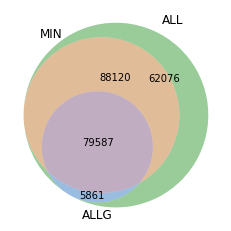

In [7]:
from matplotlib_venn import venn3
venn3([novel_tid_suff_dict["_min"],novel_tid_suff_dict["_all"],novel_tid_suff_dict["_allg"]], ('MIN', 'ALL', 'ALLG'))

In [3]:
# label cofidence

# load high-confidence set of transcripts
tps = {"_all":2,
       "_min":1,
       "_allg":0}

confidence = dict()

for suff,val in tps.items():
    with open(base_dir+"step2/all"+suff+".gtf","r") as inFP:
        for line in inFP:
            if line[0]=="#":
                continue
            
            line = line.rstrip()
            lcs = line.split("\t")
            if lcs[2]=="transcript":
                tx_type = lcs[8].split("type \"",1)[1].split("\"",1)[0]
                if tx_type=="known":
                    continue
                tid = lcs[8].split("transcript_id \"",1)[1].split("\"",1)[0]
                confidence.setdefault(tid,9)
                confidence[tid] = min(confidence[tid],val)

In [4]:
# label source of known (Refseq/Gencode) and assign IDs and names

sources = dict()
with open(base_dir+"data/latest_gtfs/gffcmp_multi.27M/27M.known.refseq_gencode.gtf","r") as inFP:
    for line in inFP.readlines():
        lcs = line.split("\t")
        if len(lcs)<9:
            continue

        if lcs[2]=="transcript":
            tid = lcs[8].split("transcript_id \"",1)[1].split("\"",1)[0]
            srcs = lcs[8].split("source \"",1)[1].split("\"",1)[0]
            assert tid not in sources,"duplicate sources"
            
            # for each source get ID and gene_name
            attrs = {"source":srcs}
            for s in srcs.split(","):
                assert s+"_ID" in lcs[8],"source ID not found: "+line
                sid = lcs[8].split(s+"_ID \"",1)[1].split("\"",1)[0]
                attrs[s+"_ID"]=sid
                assert s+"_gene_name" in lcs[8],"source gene_name not found: "+line
                sgn = lcs[8].split(s+"_gene_name \"",1)[1].split("\"",1)[0]
                attrs[s+"_gene_name"]=sgn
            
            sources[tid] = attrs

In [5]:
with open(base_dir+"step2/chess.gtf","w+") as outFP:
    with open(base_dir+"step2/all_all.gtf","r") as inFP:
        for line in inFP:
            if line[0]=="#":
                outFP.write(line)
            
            line = line.rstrip()
            lcs = line.split("\t")
            if lcs[2]=="transcript":
                tx_type = lcs[8].split("type \"",1)[1].split("\"",1)[0]
                tid = lcs[8].split("transcript_id \"",1)[1].split("\"",1)[0]
                if tx_type=="known":
                    assert tid in sources,"unknown known tid: "+tid
                    for k,v in sources[tid].items():
                        lcs[8] = lcs[8]+" "+k+" \""+v+"\";"
                    line = "\t".join(lcs)
                else:
                    assert tid in confidence,"tid not found: "+tid
                    lcs[8] = lcs[8]+" confidence \""+str(confidence[tid])+"\";"
                    line = "\t".join(lcs)
            outFP.write(line+"\n")